#### Ingestion of the cleaned dataset

In [22]:
# Imports
import pandas as pd
import boto3
from io import StringIO
import os

In [27]:
# Load variables from .env file, ignoring lines without '='
def load_env_variables(env_file='../.env'):
    # Get the current working directory
    current_dir = os.getcwd()
    env_path = os.path.join(current_dir, '..', env_file)
    
    print(f"Looking for .env file at: {env_path}")  # Debugging output

    if not os.path.exists(env_path):
        print(f".env file does not exist at: {env_path}")
        return

    with open(env_path, 'r') as file:
        for line in file:
            # Skip lines without an equals sign or comments
            if '=' in line and not line.strip().startswith('#'):
                key, value = line.strip().split('=', 1)
                os.environ[key] = value
                print(f"Loaded {key}={value}")  # Debugging output

# Load environment variables
load_env_variables()

Looking for .env file at: c:\repos\ai-logistics\notebooks\ShipCostPredictor\classification\...\.../.env
.env file does not exist at: c:\repos\ai-logistics\notebooks\ShipCostPredictor\classification\...\.../.env


In [ ]:
# Create an S3 client
s3 = boto3.client('s3')

# Specify the bucket name and prefix (folder path)
bucket_name = os.getenv('BUCKET_NAME_ALIGNED')
prefix = os.getenv('PREFIX_KEY')

# List objects in the specified S3 folder
response = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix)

# Initialize a list to store CSV file keys
csv_files = []

# Iterate over the objects and collect keys of CSV files
for obj in response.get('Contents', []):
    object_key = obj['Key']
    if object_key.endswith('.csv'):
        print(str(object_key))
        csv_files.append(object_key)


# Fetch the content of the second CSV file from S3
obj = s3.get_object(Bucket=bucket_name, Key=csv_files[1])

# Read the content of the CSV file
csv_content = obj['Body'].read().decode('utf-8')

# Use pandas to read the CSV content into a DataFrame
df= pd.read_csv(StringIO(csv_content))

In [20]:
# Define the path to the local file
#file_path = 'data/Sample_Data_Product_Cleaned.csv'

# Load the data into a pandas DataFrame
#df = pd.read_csv(file_path)

# Display the DataFrame
df.head()


,product_type,sku,estimated_price,availability,number_of_products_sold,revenue_generated,customer_demographics,stock_levels,lead_times,order_quantities,...,production_volumes,manufacturing_lead_time,manufacturing_costs,inspection_results,defect_rates,transportation_modes,routes,costs,demurrage,demurrage_bin
0,cosmetics,062000007,22790.0,17.0,715.0,8656.12,Non-binary,58.0,24.0,79.0,...,168.0,21.0,71.42,Pending,3.35,Rail,Route_B,407.65,0.0,False
1,cosmetics,1VBA0260GE,53970.0,78.0,949.0,4516.14,Unknown,75.0,15.0,90.0,...,617.0,28.0,80.63,Pass,4.66,Rail,Route_A,424.80,1633889.0,True
2,skincare,1VBF0810GE,80180.0,44.0,687.0,6449.54,Male,97.0,20.0,10.0,...,306.0,17.0,65.34,Pending,0.61,Air,Route_B,603.41,0.0,False
3,skincare,1VMG0080GE,62870.0,46.0,903.0,1755.28,Female,18.0,21.0,98.0,...,486.0,29.0,29.09,Fail,3.09,Rail,Route_C,331.07,0.0,False
4,skincare,1VMG0140GE,83820.0,99.0,163.0,7097.87,Non-binary,88.0,18.0,50.0,...,941.0,17.0,97.18,Pending,2.58,Road,Route_B,392.25,0.0,False


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   product_type             1640 non-null   object 
 1   sku                      1640 non-null   object 
 2   estimated_price          1640 non-null   float64
 3   availability             1640 non-null   float64
 4   number_of_products_sold  1640 non-null   float64
 5   revenue_generated        1640 non-null   float64
 6   customer_demographics    1640 non-null   object 
 7   stock_levels             1640 non-null   float64
 8   lead_times               1640 non-null   float64
 9   order_quantities         1640 non-null   float64
 10  shipping_times           1640 non-null   float64
 11  shipping_carriers        1640 non-null   object 
 12  shipping_costs           1640 non-null   float64
 13  supplier_name            1640 non-null   object 
 14  location                

In [16]:
# Filter the DataFrame to include only rows where 'demurrage_bin' is True
filtered_df = df[df['demurrage_bin'] == True]

# Create the new DataFrame with only 'sku' and 'demurrage_bin' columns
classification_df = filtered_df[['sku', 'demurrage_bin']]

# Display the new DataFrame
classification_df.head()

#classification_df.to_csv('data/supply_chain_classification.csv', index=False)


,sku,demurrage_bin
1,1VBA0260GE,True
6,1VRH0080GE,True
7,1VRH0090GE,True
8,1VRT0450GE,True
11,2VST0080CB,True


In [17]:
# Create an S3 client
s3 = boto3.client('s3')

# Save the concatenated DataFrame to S3
output_bucket_name = 'logimo-aligned'
output_prefix = 'ship_cost_predictor/Demurrage_Classification.csv'
csv_buffer = StringIO()
classification_df.to_csv(csv_buffer, index=False)

# Upload the CSV to S3
s3.put_object(Bucket=output_bucket_name, Key=output_prefix, Body=csv_buffer.getvalue())

print(f"Concatenated file saved to s3://{output_bucket_name}/{output_prefix}")

Concatenated file saved to s3://logimo-aligned/ship_cost_predictor/Demurrage_Classification.csv


In [18]:
df.columns

Index(['product_type', 'sku', 'estimated_price', 'availability',
       'number_of_products_sold', 'revenue_generated', 'customer_demographics',
       'stock_levels', 'lead_times', 'order_quantities', 'shipping_times',
       'shipping_carriers', 'shipping_costs', 'supplier_name', 'location',
       'lead_time', 'production_volumes', 'manufacturing_lead_time',
       'manufacturing_costs', 'inspection_results', 'defect_rates',
       'transportation_modes', 'routes', 'costs', 'demurrage',
       'demurrage_bin'],
      dtype='object')

In [19]:
### WE DROP: 
# sku, 
# availability, 
# customer_demographics,
# revenue_generated, 

### WE KEEP: 
# estimated_price, 
# transportation_modes,
# inspection_results,
# routes,
# costs,
# defect_rates,
# manufacturing_lead_time, 
# production_volumes, 
# order_quantities, 
# lead_times, 
# stock_levels, 
# number_of_products_sold	 

In [160]:
from sklearn.preprocessing import StandardScaler

# Drop irrelevant columns if any (example)
df = df.drop(['sku', 'demurrage', 'customer_demographics', 'supplier_name' ], axis=1) #'product_type'

# Convert categorical variables to dummy variables
df = pd.get_dummies(df)


# Define features and target
X = df.drop('demurrage_bin', axis=1)
y = df['demurrage_bin']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [173]:
# Dataframe for ml classification training
df.to_csv('data/supply_chain_ml_classification.csv', index=False)

In [161]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Neural Network": Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
}

# Train and evaluate each model
for name, model in models.items():
    if name == "Neural Network":
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0)
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")


/Users/faustobravocuvi/envs/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Random Forest Accuracy: 0.5975609756097561
Logistic Regression Accuracy: 0.5711382113821138
SVM Accuracy: 0.5853658536585366
Neural Network Accuracy: 0.5630081295967102


In [162]:
# # Define parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
# }

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [4, 6, 8, 10, 12]
}


# Initialize Grid Search
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Optimized Random Forest Accuracy: {accuracy}")


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.1s
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=4, n_estimators=100; total time=   0.2s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.3s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.2s
[CV] END ......................max_depth=4, n_estimators=200; total time=   0.4s
[CV] END ......................max_depth=4, n_estimators=300; total time=   0.4s
[CV] END ......................max_depth=4, n_e

In [163]:
# Train and evaluate each model
for name, model in models.items():
    if name == "Neural Network":
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs=10, batch_size=10, verbose=0)
        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
        
        # Save the neural network model
        model.save(f'{name.lower().replace(" ", "_")}_model.h5')
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        
        # Save the model using pickle
        with open(f'{name.lower().replace(" ", "_")}_model.pkl', 'wb') as f:
            pickle.dump(model, f)
    
    print(f"{name} Accuracy: {accuracy}")

# Save the scaler using pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Random Forest Accuracy: 0.5833333333333334
Logistic Regression Accuracy: 0.5711382113821138
SVM Accuracy: 0.5853658536585366
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Neural Network Accuracy: 0.5121951103210449


#### Visualization of each feature importance

Visualizing feature importance helps understand which features have the most impact on the prediction of the target variable in a RandomForest model.

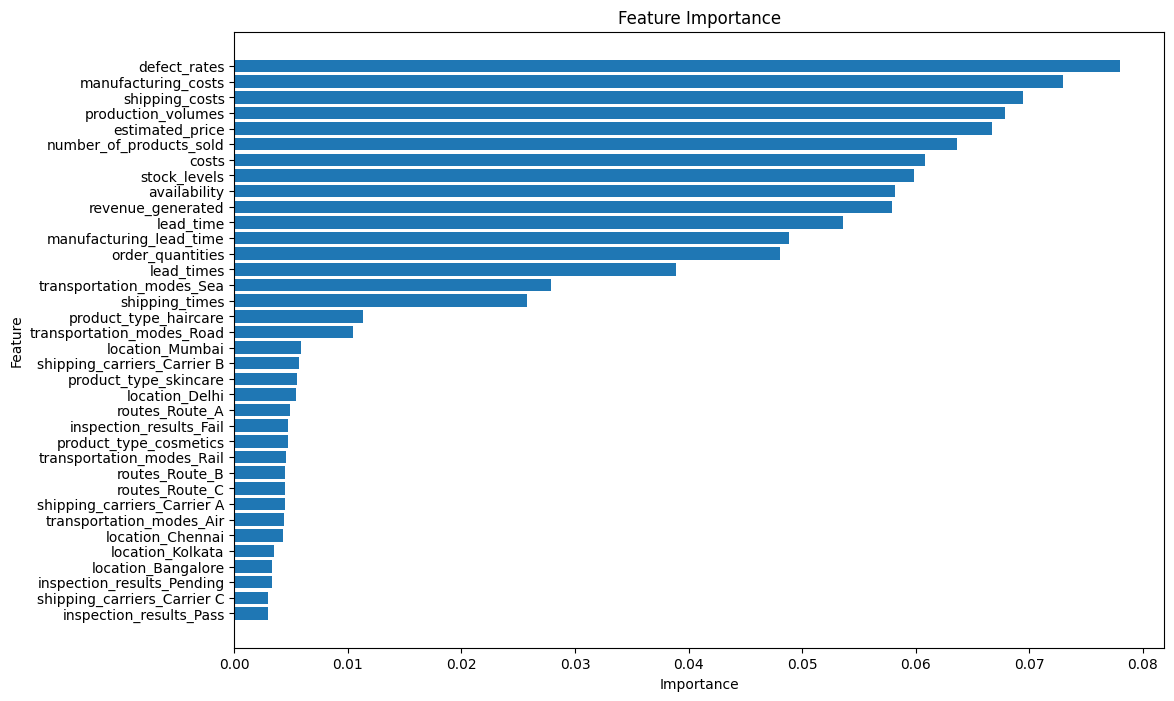

In [164]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get feature importances
importances = best_model.feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Filter the DataFrame to include only rows where 'demurrage_bin' is True
filtered_df = df[df['demurrage_bin'] == True]

# Create the new DataFrame with only 'sku' and 'demurrage_bin' columns
classification_df = filtered_df[['sku', 'demurrage_bin']]

# Display the new DataFrame
classification_df.head()

classification_df.to_csv('data/supply_chain_classification.csv', index=False)
